In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import dblquad
from math import *
import scipy.stats
from pandas import *
from scipy.integrate import quad
import seaborn as sns
import scipy as s
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits import mplot3d
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objects as go
from scipy import linalg
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import rc

from concurrent.futures import ProcessPoolExecutor

# !apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# # Enable LaTeX rendering
# rc('text', usetex=True)
# rc('font', family='serif', size=12)



# Set data type
DTYPE='float32'
# tf.keras.backend.set_floatx(DTYPE)

In [5]:
import numpy as np
from scipy.integrate import dblquad
from concurrent.futures import ProcessPoolExecutor
import time

"""
The code here is to be used for the term(s) required in the Fredholm Neural Network and Limit Informed Neural Network.
We want to calculatate the integral of fundamental*source. This is used in:

a) The calculation of the additive term in the FNN. For this term we are calculating it on the boundary, i.e., for r _out = 1
b) The calculation of the bias in the LINN

These are parallelized using SciPy's dblquad for speed and accuracy with weakly singular integrands (SciPy error ~ E-15 vs. Torch methods error ~ E-05)

"""

tol = 1e-08

### Scalar functions for dblquad
def fundamental_fn_scalar(r_2, theta, r_out, theta_out):
    """
    Scalar version of the fundamental function for numerical integration.
    """
    fund = (1 / (2 * np.pi)) * 0.5 * np.log(
        (r_out * np.cos(theta_out) - r_2 * np.cos(theta))**2 +
         (r_out * np.sin(theta_out) - r_2 * np.sin(theta))**2
    ) * r_2

    return fund

def source_term_fn_scalar(r_2, theta):
    """
    Scalar version of the source term function for numerical integration.
    """
    return 0 #2 * r_2 * np.cos(theta)

def integrand_scalar(theta, r_2, r_out, theta_out):
    """
    Integrand using scalar versions of fundamental_fn and source_term_fn.
    """
    fundamental = fundamental_fn_scalar(r_2, theta, r_out, theta_out)
    source_term = source_term_fn_scalar(r_2, theta)
    return source_term * fundamental

def inner_integration(integrand, r_2, r_out, theta_out):
    """
    Performs the inner integration over theta for a fixed r_2.
    Handles the weak singularity at theta = theta_out if r_2 is close to r_out.
    """
    # Define the integrand as a function of theta only.
    f_theta = lambda theta: integrand(theta, r_2, r_out, theta_out)
    # If r_2 is nearly equal to r_out, specify the singular point
    if np.abs(r_2 - r_out) < tol:
        result, error = quad(f_theta, 0, 2*np.pi, points=[theta_out])
    else:
        result, error = quad(f_theta, 0, 2*np.pi)
    return result


def full_integration(integrand, r_out, theta_out):
    """
    Performs the full integration: first over theta (inner) then over r_2 (outer).
    """
    # Define the outer integrand: result of integrating over theta at fixed r_2.
    f_r2 = lambda r_2: inner_integration(integrand, r_2, r_out, theta_out)
    result, error = quad(f_r2, 0, 1, points=[r_out])
    return result, error


def integrate_for_out_value_scalar(args):
    """
    Performs scalar integration for a single (r_out, theta_out) value using two-step integration.
    """
    r_out, theta_out = args  # Unpack the tuple
    result, error = full_integration(integrand_scalar, r_out, theta_out)
    return result


def parallel_integrate_meshgrid(r_out_values, theta_out_values):
    """
    Parallel integration for all (r_out, theta_out) values on a meshgrid using sequential quad integrations.

    Args:
        r_out_values (np.array): 1D array of r_out values.
        theta_out_values (np.array): 1D array of theta_out values.

    Returns:
        np.array: 2D array of integral results with shape (len(r_out_values), len(theta_out_values)).
    """
    # Create a meshgrid for r_out and theta_out (first axis: r_out, second: theta_out)
    R_out, Theta_out = np.meshgrid(r_out_values, theta_out_values, indexing='ij')

    # Flatten the meshgrid for parallel processing:
    out_values = np.column_stack((R_out.ravel(), Theta_out.ravel()))

    # Perform the integrations in parallel over the list of (r_out, theta_out) pairs.
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(integrate_for_out_value_scalar, out_values))

    # Reshape the results to the original meshgrid shape.
    results_array = np.array(results).reshape(R_out.shape)

    return results_array

# Define range of r_out and theta_out
# r_out_values = np.linspace(0, 1, 100)
# theta_out_values = np.linspace(0, 2*np.pi, 100)

# # Compute integral in parallel
# t_0 = time.time()
# integral_results = parallel_integrate_meshgrid(r_out_values, theta_out_values)
# t_1 = time.time()
# print(t_1 - t_0)
# # Print results
# print("Integral Results Shape:", integral_results.shape)
# print("Integral Results:", integral_results)

In [6]:
"""
Tensor-compatible functions for vectorized calculations and numerical integration in the FredholmNN.
"""

def func_fn(out_value):
    """
    Boundary function of the PDE
    """
    return 1+np.cos(2*out_value) #0.0

def kernel(in_value, out_value):
    """
    Kernel in the BIE
    """
    weight = (1.0 / (4.0 * np.pi * np.sqrt(1.0))) * np.ones_like(in_value - out_value)
    return (-2) * weight


"""
Tensor-compatible functions for vectorized calculations in the LimitInformedNN.
"""

# Updated diff_potentials_limit to return a tensor
def diff_potentials_limit(phi_integral, r_out, theta_out):
    r_out = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))

    # Create meshgrid for broadcasting
    r_out_grid, theta_out_grid, phi_integral_grid = torch.meshgrid(
        r_out, theta_out, torch.tensor(phi_integral, dtype=torch.float32), indexing='ij'
    )

    # Boundary condition: r_out == 1.0
    boundary_mask = (r_out_grid == 1.0)

    # Integral kernel for r_out != 1
    integral_kernel_num = torch.cos(phi_integral_grid) * (torch.cos(phi_integral_grid) - r_out_grid * torch.cos(theta_out_grid)) + \
                          torch.sin(phi_integral_grid) * (torch.sin(phi_integral_grid) - r_out_grid * torch.sin(theta_out_grid))
    integral_kernel_den = (torch.cos(phi_integral_grid) - r_out_grid * torch.cos(theta_out_grid))**2 + \
                          (torch.sin(phi_integral_grid) - r_out_grid * torch.sin(theta_out_grid))**2
    integral_kernel = integral_kernel_num / integral_kernel_den

    # Set kernel to 0.5 where r_out == 1.0
    integral_kernel[boundary_mask] = 0.5

    # Final kernel limit
    kernel_limit = (1.0 / (2.0 * np.pi)) * (integral_kernel - 0.5)

    return kernel_limit

# Updated potential_boundary to return a tensor
def potential_boundary(phi_integral, r_out, theta_out):
    r_out = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))

    # Create meshgrid for broadcasting
    r_out_grid, theta_out_grid, phi_integral_grid = torch.meshgrid(
        r_out, theta_out, torch.tensor(phi_integral, dtype=torch.float32), indexing='ij'
    )

    integral_kernel = (1.0 / (2.0 * np.pi)) * 0.5  # Constant value

    return torch.full(r_out_grid.shape, integral_kernel, dtype=torch.float32)


In [7]:
"""
FredholmNeuralNetwork class definition.
"""

class FredholmNeuralNetwork(nn.Module):
    def __init__(self, grid_dictionary, kernel, grid_step, K, input_size, output_size, km_constant, func_fn):
        super(FredholmNeuralNetwork, self).__init__()

        self.grid_dictionary = grid_dictionary
        self.kernel = kernel
        self.grid_step = grid_step
        self.K = K
        self.km_constant = km_constant
        self.func_fn = func_fn

        # Store dimensions for each layer
        self.layer_sizes = [input_size] + [len(grid_dictionary[f'layer_{i}']) for i in range(K + 1)]

    def additive(self, out_values):


        # Compute the additive term
        additive_values = 2 * (self.func_fn(out_values))

        return np.array(additive_values)

    def compute_weights_and_biases(self):
        """Precomputes weights and biases based on the grid using vectorized operations."""
        weights = []
        biases = []

        for i in range(self.K + 1):
            if i == 0:
                # Boundary condition for the first layer
                mat = np.identity(self.layer_sizes[i])
                weights.append(torch.tensor(mat, dtype=torch.float32))
                biases.append(torch.zeros(self.layer_sizes[i], dtype=torch.float32))
            else:
                # Vectorized kernel computation for weight matrix
                grid_prev = np.expand_dims(self.grid_dictionary[f'layer_{i - 1}'], axis=1)  # [N, 1]
                grid_curr = np.expand_dims(self.grid_dictionary[f'layer_{i}'], axis=0)    # [1, M]

                weight_matrix = (
                    self.kernel(grid_prev, grid_curr) * self.grid_step * self.km_constant +
                    (1 - self.km_constant) * ((grid_prev - grid_curr) == 0.0)
                )  # [N, M]
                weights.append(torch.tensor(weight_matrix, dtype=torch.float32))

                # Squeeze grid_curr from shape [1, M] to [M]
                grid_curr_squeezed = grid_curr.squeeze(0)  # shape [M]

                # Compute the additive term => shape (M,)
                bias_vector = self.additive(grid_curr_squeezed)*self.km_constant
                biases.append(torch.tensor(bias_vector, dtype=torch.float32))

        return weights, biases

    def forward(self, predict_array):
        # Precompute weights and biases
        weights, biases = self.compute_weights_and_biases()

        # Pass input through the dynamically updated network
        x = torch.ones(len(self.grid_dictionary['layer_0']), dtype=torch.float32)
        for i in range(self.K + 1):
            x = torch.matmul(weights[i].T, x) + biases[i]

        # Compute the last hidden layer output
        prediction = x

        return prediction.squeeze()

In [8]:
"""
Potential Fredholm Neural Network class with precalculated integral using parallelized dblquad

In this Poisson example we only need to pass the integral fundamental*source for (r_o, theta_o) that will be added to the bias term
"""

class PotentialFredholmNeuralNetwork(nn.Module):
    def __init__(self, fredholm_model, diff_potentials_fn, potential_boundary_fn, plot_BIF=False):
        super(PotentialFredholmNeuralNetwork, self).__init__()
        self.fredholm_model = fredholm_model
        self.diff_potentials_fn = diff_potentials_fn
        self.potential_boundary_fn = potential_boundary_fn
        self.plot_BIF = plot_BIF

    def forward(self, input, r_out, theta_out, phi_grid, grid_step):
        phi_grid = torch.tensor(phi_grid, dtype=torch.float32) if isinstance(phi_grid, np.ndarray) else phi_grid
        theta_out = torch.tensor(theta_out, dtype=torch.float32) if isinstance(theta_out, np.ndarray) else theta_out

        fnn_output = self.fredholm_model(input).to(dtype=torch.float32)

        if self.plot_BIF:
          plt.figure(figsize=(5, 4))
          plt.plot(input.numpy(), fnn_output.detach().numpy(), label="Model Output")
          plt.xlabel("Predict Array (x_list)")
          plt.ylabel("Output")
          plt.title("Boundary function")
          plt.legend()
          plt.grid(True)
          plt.show()

        # Additional hidden layer
        hidden_weights = torch.eye(len(phi_grid), dtype=torch.float32) # Construct Identity matrix for the weights in the additional hidden layer
        theta_indices = torch.argmin(torch.abs(phi_grid.unsqueeze(0) - theta_out.unsqueeze(-1)), dim=-1) # find corresponding β(x*) for substraction below
        fnn_output_theta = fnn_output[theta_indices]
        fnn_output_theta_expanded = fnn_output_theta.unsqueeze(0).repeat(len(r_out), 1).unsqueeze(-1)
        hidden_bias = -fnn_output_theta_expanded
        hidden_output = fnn_output.unsqueeze(0).unsqueeze(0) + hidden_bias

        # Output layer - r_out and theta_out are "tensored" via the potential and diff potential functions
        output_weights = torch.tensor(self.diff_potentials_fn(phi_grid, r_out, theta_out) * grid_step, dtype=torch.float32) # Multiply by the difference in potentials for the limit-approaching term
        potential_boundary_term = self.potential_boundary_fn(phi_grid, r_out, theta_out)

        bias_output = (
            torch.sum(fnn_output.unsqueeze(0).unsqueeze(0) * potential_boundary_term, dim=-1) * grid_step +
            0.5 * fnn_output_theta.unsqueeze(0).repeat(len(r_out), 1)) # Calculate the first part of the bias term as the integral of the potential kernel*boundary function

        output_weights = output_weights.unsqueeze(-1)
        final_output = torch.matmul(hidden_output.unsqueeze(-2), output_weights).squeeze(-2)
        final_output += bias_output.unsqueeze(-1)
        return final_output


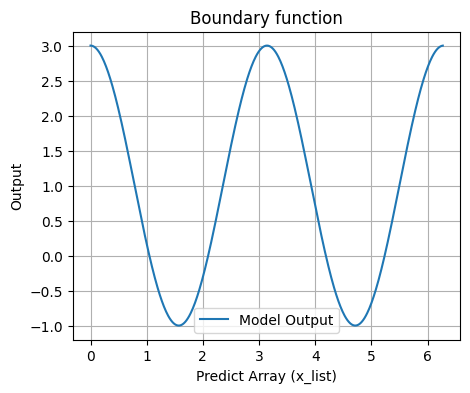

Forward pass time: 0.966880 seconds


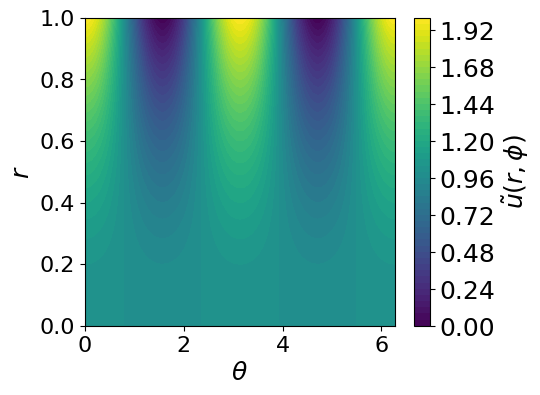

In [9]:
import time

# Constants
a = 1
b = -1
c = 1

# Function to compute the Laplace solution in Cartesian coordinates
def laplace_solution_cartesian(x, y):
    return a * x**2 + b * y**2 + c


# Function to compute the Laplace solution in polar coordinates
def laplace_solution_polar(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return laplace_solution_cartesian(x, y)

K = 30
phi_grid_dict = {}
for i in range(0, K + 1):
    phi_0 = 0.0
    phi_n = 2.0 * np.pi
    phi_steps = 500
    dphi = (phi_n - phi_0) / phi_steps
    phi = np.arange(phi_0, phi_n, dphi)
    phi_grid_dict[f'layer_{i}'] = phi


r_out = np.linspace(0, 1, 100)
theta_out = phi
theta_out_torch = torch.tensor(theta_out, dtype=torch.float32)

t0 = time.time()


# Model parameters
input_size = len(theta_out)
output_size = len(theta_out)
km_constant = 0.3


t2 = time.time()

# Instantiate the Fredholm model
fredholm_model = FredholmNeuralNetwork(
    phi_grid_dict, kernel, dphi, K, input_size, output_size, km_constant,
    func_fn)

# Instantiate the LimitInformed model with the precomputed integral for r_out == 1
limit_informed_model = PotentialFredholmNeuralNetwork(
    fredholm_model=fredholm_model,
    diff_potentials_fn=diff_potentials_limit,
    potential_boundary_fn=potential_boundary,
    plot_BIF=True)

# Forward pass
output = limit_informed_model(
    input=theta_out_torch,
    r_out=r_out,
    theta_out=theta_out,
    phi_grid=phi,
    grid_step=dphi
)

t3 = time.time()
print(f"Forward pass time: {t3 - t2:.6f} seconds")

# Extract data for visualization
data = output.detach().numpy()[:, :, 0]

# Contour plot for visualization in (r, theta) space
R_out, Theta_out = np.meshgrid(r_out, theta_out, indexing='ij')
plt.figure(figsize=(5, 4))
plt.contourf(Theta_out, R_out, data, levels=50, cmap='viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"$\tilde{u}(r,\phi)$", fontsize=18)
plt.xlabel(r"$\theta$", fontsize=18)
plt.ylabel(r"$r$", fontsize=18)
plt.tick_params(axis='both', labelsize=16)
plt.show()


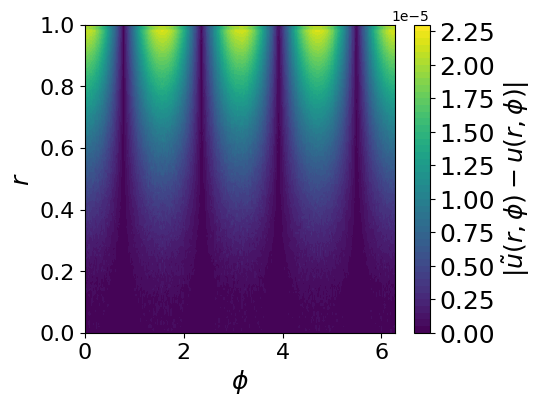

In [10]:
#### Errors wrt to real solution #################################

# Create the contour plot for the absolute error
difference = np.abs(data - laplace_solution_polar(R_out, Theta_out))
plt.figure(figsize=(5, 4))
plt.contourf(Theta_out, R_out, difference, levels=50, cmap='viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks
cbar.set_label(r"$|\tilde{u}(r,\phi) - u(r,\phi)|$", fontsize=18)  # Increase font size for colorbar label
plt.xlabel(r"$\phi$", fontsize=18)
plt.ylabel(r"$r$", fontsize=18)
plt.tick_params(axis='both', labelsize=16)  # Increase font size for x and y ticks
plt.show()

In [11]:
np.mean(difference[:-1,:])

np.float64(4.668850427629563e-06)

In [12]:
np.mean(difference[-1,:])

np.float64(1.4234782032818805e-05)